### Import Of Necessary Libraries

In [1]:
# Core Python Libraries
import os  # Operating system interactions, such as reading and writing files.
import shutil  # High-level file operations like copying and moving files.
import random  # Random number generation for various tasks.
import textwrap  # Formatting text into paragraphs of a specified width.

# PyTorch-related Libraries (Deep Learning)
import torch  # Core PyTorch library for tensor computations.
import torch.nn as nn  # Neural network module for defining layers and architectures.
import torch.optim as optim  # Optimizer module for training models (SGD, Adam, etc.).
from torch.utils.data import Dataset, DataLoader  # Dataset and DataLoader for managing and batching data.
import torchvision.transforms as transforms  # Transformations for image preprocessing.

# Geospatial Data Processing Libraries
import rasterio  # Library for reading and writing geospatial raster data.
from rasterio.warp import calculate_default_transform, reproject  # Reprojection and transformation functions.
from rasterio.enums import Resampling  # Resampling methods used for resizing raster data.
from rasterio.plot import show  # Visualization of raster data.


# Data Manipulation and Analysis Libraries
import pandas as pd  # Data analysis and manipulation library for DataFrames and CSVs.
import numpy as np  # Numpy for array operations and numerical computations.

# Visualization Libraries
import matplotlib.pyplot as plt  # Plotting library for creating static and interactive visualizations.
import seaborn as sns  # High-level interface for drawing attractive statistical graphics.

# Utilities
from tqdm import tqdm  # Progress bar for loops and processes.
from PIL import Image  # Image handling, opening, manipulating, and saving.

### Load the Meta Data and Set Base directory

In [2]:
# Load the metadata
metadata_df = pd.read_parquet(r'C:\Users\isaac\Downloads\metadata.parquet')
# Load the metadata for the snow/cloud/shadow data
snow_cloud_shadow_metadata_df = pd.read_parquet(r'C:\Users\isaac\Downloads\metadata_for_patches_with_snow_cloud_or_shadow.parquet')

# Base directories
source_dir = r'C:\Users\isaac\Desktop\BigEarthTests\OnePercentBigEarthNet'

In [3]:
# Get the number of rows in the DataFrame
num_rows = metadata_df.shape[0]

# Print the number of rows in the DataFrame, followed by a blank line
print(f"The DataFrame contains {num_rows} rows.\n")

# Display the column names in the DataFrame, followed by a blank line
print("Column Names:")
print(metadata_df.columns, "\n")

# Display the first few rows of the DataFrame with a preceding message
print("First few rows of the DataFrame:")
print(metadata_df.head())

The DataFrame contains 480038 rows.

Column Names:
Index(['patch_id', 'labels', 'split', 'country', 's1_name', 's2v1_name',
       'contains_seasonal_snow', 'contains_cloud_or_shadow'],
      dtype='object') 

First few rows of the DataFrame:
                                            patch_id  \
0  S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_2...   
1  S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_2...   
2  S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_2...   
3  S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_2...   
4  S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_2...   

                                              labels split  country  \
0  [Arable land, Broad-leaved forest, Mixed fores...  test  Austria   
1  [Arable land, Broad-leaved forest, Inland wate...  test  Austria   
2  [Arable land, Broad-leaved forest, Coniferous ...  test  Austria   
3  [Broad-leaved forest, Complex cultivation patt...  test  Austria   
4  [Broad-leaved forest, Complex cultivation patt...  test  Austr

In [4]:
# Extract unique labels from the metadata dataframe
unique_labels = metadata_df['labels'].explode().unique()

# Print the unique labels in a numbered table format
print("Unique Labels:")
for i, label in enumerate(unique_labels, start=1):
    print(f"{i}. {label}")

Unique Labels:
1. Arable land
2. Broad-leaved forest
3. Mixed forest
4. Pastures
5. Inland waters
6. Coniferous forest
7. Complex cultivation patterns
8. Land principally occupied by agriculture, with significant areas of natural vegetation
9. Urban fabric
10. Industrial or commercial units
11. Inland wetlands
12. Transitional woodland, shrub
13. Natural grassland and sparsely vegetated areas
14. Moors, heathland and sclerophyllous vegetation
15. Marine waters
16. Coastal wetlands
17. Permanent crops
18. Beaches, dunes, sands
19. Agro-forestry areas


In [5]:
def create_binary_vector(labels, categories):
    vector = [1 if category in labels else 0 for category in categories]
    return vector

# Step 3: Apply the function to each row in the DataFrame
metadata_df['binary_vector'] = metadata_df['labels'].apply(lambda labels: create_binary_vector(labels, unique_labels))

# Display the column names in the DataFrame, followed by a blank line
print("Column Names:")
print(metadata_df.columns, "\n")

# Display the first few rows to verify the new column
print(metadata_df.head())

Column Names:
Index(['patch_id', 'labels', 'split', 'country', 's1_name', 's2v1_name',
       'contains_seasonal_snow', 'contains_cloud_or_shadow', 'binary_vector'],
      dtype='object') 

                                            patch_id  \
0  S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_2...   
1  S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_2...   
2  S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_2...   
3  S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_2...   
4  S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_2...   

                                              labels split  country  \
0  [Arable land, Broad-leaved forest, Mixed fores...  test  Austria   
1  [Arable land, Broad-leaved forest, Inland wate...  test  Austria   
2  [Arable land, Broad-leaved forest, Coniferous ...  test  Austria   
3  [Broad-leaved forest, Complex cultivation patt...  test  Austria   
4  [Broad-leaved forest, Complex cultivation patt...  test  Austria   

                                        s1_nam

In [48]:
# Write the updated DataFrame to a CSV file
metadata_df.to_csv(r'C:\Users\isaac\Downloads\metadata.csv', index=False)

print("Data has been successfully copied to metadata.csv")

Data has been successfully copied to metadata.csv


In [49]:
# Create a new DataFrame with patch_id and binary vector columns
binary_vectors_df = pd.DataFrame(metadata_df['binary_vector'].tolist(), columns=unique_labels)
binary_vectors_df.insert(0, 'patch_id', metadata_df['patch_id'])

# Save the new DataFrame to a CSV file
binary_vectors_df.to_csv(r'C:\Users\isaac\Downloads\metadata_with_binary_vectors.csv', index=False)

print("Data has been successfully copied to metadata_with_binary_vectors.csv")

Data has been successfully copied to metadata_with_binary_vectors.csv


In [39]:
row = metadata_df.loc[metadata_df['patch_id'] == 'S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_29_59']

labels = row['labels'].values[0]
binary_vector = row['binary_vector'].values[0]

print(f"Labels: {labels}")
print(f"Binary Vector: {binary_vector}")

Labels: ['Arable land', 'Broad-leaved forest', 'Land principally occupied by agriculture, with significant areas of natural vegetation', 'Pastures', 'Urban fabric']
Binary Vector: [1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [11]:
# Filter patches that contain both "Urban fabric" and any type of forest
urban_forest_patches = metadata_df[
    metadata_df['labels'].apply(lambda x: 'Urban fabric' in x and any(forest in x for forest in ['Broad-leaved forest', 'Mixed forest', 'Coniferous forest']))
]

# Limit the output to 1
limited_patch = urban_forest_patches.head(1)

# Set display option to avoid truncation
pd.set_option('display.max_colwidth', None)  # None means no limit

# Display the result
print(limited_patch[['patch_id', 'labels']])

                                             patch_id  \
7  S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_27_61   

                                                         labels  
7  [Broad-leaved forest, Inland waters, Pastures, Urban fabric]  


### Count and Remote Patches containing cloud or shadow

In [ ]:
# Initialize counters
true_count = 0
false_count = 0

# Iterate through all folders in the base directory
for folder_name in tqdm(os.listdir(source_dir), desc="Processing folders"):
    folder_path = os.path.join(source_dir, folder_name)
    for patch_name in os.listdir(folder_path):
        patch_path = os.path.join(folder_path, patch_name)

        # Filter the DataFrame to get the row with the matching patch_id
        matching_row = snow_cloud_shadow_metadata_df.loc[metadata_df['patch_id'] == patch_name]

         # If a match is found, extract the labels
        if not matching_row.empty:
            contains_cloud_or_shadow = matching_row['contains_cloud_or_shadow'].values[0]
            if contains_cloud_or_shadow:
                true_count += 1
                shutil.rmtree(patch_path)
            else:
                false_count += 1

# Print the results
print(f"Total True (contains_cloud_or_shadow): {true_count}")
print(f"Total False (contains_cloud_or_shadow): {false_count}")

In [ ]:
# Initialize a counter for deleted folders
deleted_folders_count = 0

# Loop through each row in the DataFrame with a progress bar
for index, row in tqdm(snow_cloud_shadow_metadata_df.iterrows(), total=len(snow_cloud_shadow_metadata_df), desc="Processing files"):
    patch_id = row['patch_id']  # Adjust if the column name differs
    # Extract the folder name (all but the last part of the patch_id)
    folder_name = '_'.join(patch_id.split('_')[:-2])
    dest_dir = os.path.join(source_dir, folder_name, patch_id)  # Use os.path.join for better path handling
    
    # If dest_dir exists, delete it
    if os.path.exists(dest_dir):
        shutil.rmtree(dest_dir)  # Remove the directory and its contents
        deleted_folders_count += 1  # Increment the counter

# Print the total number of deleted folders
print(f"Total deleted folders: {deleted_folders_count}")

### Function to Resize TIFF images

In [75]:
def resize_tiff(input_tif, output_tif, new_width, new_height):
    with rasterio.open(input_tif) as src:
        # Calculate the transform for the new dimensions
        transform, width, height = calculate_default_transform(
            src.crs, src.crs, new_width, new_height, *src.bounds
        )

        kwargs = src.meta.copy()
        kwargs.update({
            'crs': src.crs,
            'transform': transform,
            'width': new_width,
            'height': new_height,
            'dtype': 'uint16'  # Adjust dtype as necessary
        })

        with rasterio.open(output_tif, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=src.crs,
                    resampling=Resampling.nearest
                )

### Resize and Replace Bands in all subfolders

In [76]:
bands_of_interest = ['B01', 'B05', 'B06', 'B07', 'B8A', 'B09', 'B11', 'B12']

# List all folders and subfolders
for folder in os.listdir(source_dir):
    folder_path = os.path.join(source_dir, folder)  # Create the full path
    if os.path.isdir(folder_path):  # Check if it's a directory
        #print(f'Folder: {folder}')
        for subfolder in os.listdir(folder_path):
            subfolder_path = os.path.join(folder_path, subfolder)
            if os.path.isdir(subfolder_path):  # Check if it's a subdirectory
                #print(f'  Subfolder: {subfolder}')
                for band in tqdm(bands_of_interest, desc=f'Processing {subfolder}', unit='band'):
                    band_source = subfolder_path + "/" + subfolder + "_" + band + ".tif"
                    temp_tif = subfolder_path + "/" + subfolder + "_" + band + "_resized.tif"
                    new_width = 120
                    new_height = 120

                    resize_tiff(band_source, temp_tif, new_width, new_height)

                    os.remove(band_source)  # Delete the original
                    os.rename(temp_tif, band_source)  # Rename the temporary file

Processing S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_29_59:   0%|          | 0/8 [00:00<?, ?band/s]

Processing S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_29_59: 100%|██████████| 8/8 [00:01<00:00,  6.41band/s]
Processing S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_31_59: 100%|██████████| 8/8 [00:01<00:00,  6.54band/s]
Processing S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_32_55: 100%|██████████| 8/8 [00:01<00:00,  6.35band/s]
Processing S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_34_51: 100%|██████████| 8/8 [00:01<00:00,  6.12band/s]
Processing S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_40_57: 100%|██████████| 8/8 [00:01<00:00,  6.28band/s]
Processing S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_41_67: 100%|██████████| 8/8 [00:01<00:00,  6.74band/s]
Processing S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_41_90: 100%|██████████| 8/8 [00:01<00:00,  6.50band/s]
Processing S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_46_69: 100%|██████████| 8/8 [00:01<00:00,  6.43band/s]
Processing S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_55_52: 100%|██████████| 8/8 [00:01<00:00,  5.89band/s]
P

In [78]:
def generate_band_paths(base_path):
    bands = ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B11', 'B12']
    return [f"{base_path}_{band}.tif" for band in bands]

def combine_tifs_to_single_file(base_path, output_path):
    band_paths = generate_band_paths(base_path)

    # Read the first image to get metadata
    with rasterio.open(band_paths[0]) as src:
        meta = src.meta.copy()
        meta.update(count=len(band_paths))  # Update the count to the number of bands

    # Create a new multi-band TIFF file
    with rasterio.open(output_path, 'w', **meta) as dst:
        for idx, path in enumerate(band_paths, start=1):
            with rasterio.open(path) as src:
                # Read each band and write it to the new file
                dst.write(src.read(1), idx)

In [79]:
source_dir = r"C:\Users\isaac\Desktop\BigEarthTests\OnePercentBigEarthNet"
destination_dir = r"C:\Users\isaac\Desktop\BigEarthTests\OnePercentBigEarthNet\CombinedImages"

if not os.path.exists(destination_dir):
    os.makedirs(destination_dir)

folders = [folder for folder in os.listdir(source_dir) if folder != "CombinedImages"]

for folder in tqdm(folders, desc="Processing folders"):
    folder_path = os.path.join(source_dir, folder)
    dest_folder_path = os.path.join(destination_dir, folder)
    if not os.path.exists(dest_folder_path):
        os.makedirs(dest_folder_path)

    subfolders = os.listdir(folder_path)
    for subfolder in tqdm(subfolders, desc=f"Processing subfolders in {folder}", leave=False):
        subfolder_path = os.path.join(folder_path, subfolder, subfolder)
        dest_subfolder_path = os.path.join(dest_folder_path, f"{subfolder}.tif")
        combine_tifs_to_single_file(subfolder_path, dest_subfolder_path)

Processing folders: 100%|██████████| 115/115 [1:11:36<00:00, 37.36s/it]


In [17]:
def display_combined_image(tif_path):
    with rasterio.open(tif_path) as src:
        # Read all bands
        bands = [src.read(i + 1) for i in range(src.count)]  # Bands are 1-indexed in rasterio
        # Normalize bands for display
        bands = [band / band.max() for band in bands]  # Normalize each band to 0-1 for visualization

        # Get metadata
        metadata = src.meta
        print("Metadata:")
        print(f"Driver: {metadata['driver']}")
        print(f"Width: {metadata['width']}")
        print(f"Height: {metadata['height']}")
        print(f"Count (Bands): {metadata['count']}")
        print(f"Data Type: {metadata['dtype']}")
        print(f"CRS: {metadata['crs']}")
        print(f"Transform: {metadata['transform']}")

    return np.dstack(bands[:3])  # Return the first three bands for RGB

In [23]:
def display_rgb_image(tif_path):
    with rasterio.open(tif_path) as src:
        # Read the bands for Red, Green, and Blue (B04, B03, B02)
        red_band = src.read(4)   
        green_band = src.read(3)  
        blue_band = src.read(2)   
        
        # Normalize RGB bands for display
        red_band = red_band / red_band.max()  # Normalize the red band
        green_band = green_band / green_band.max()  # Normalize the green band
        blue_band = blue_band / blue_band.max()  # Normalize the blue band

    return np.dstack((red_band, green_band, blue_band))  # Return the RGB image

Metadata:
Driver: GTiff
Width: 120
Height: 120
Count (Bands): 12
Data Type: uint16
CRS: EPSG:32634
Transform: | 10.00, 0.00, 532380.00|
| 0.00,-10.00, 7007640.00|
| 0.00, 0.00, 1.00|


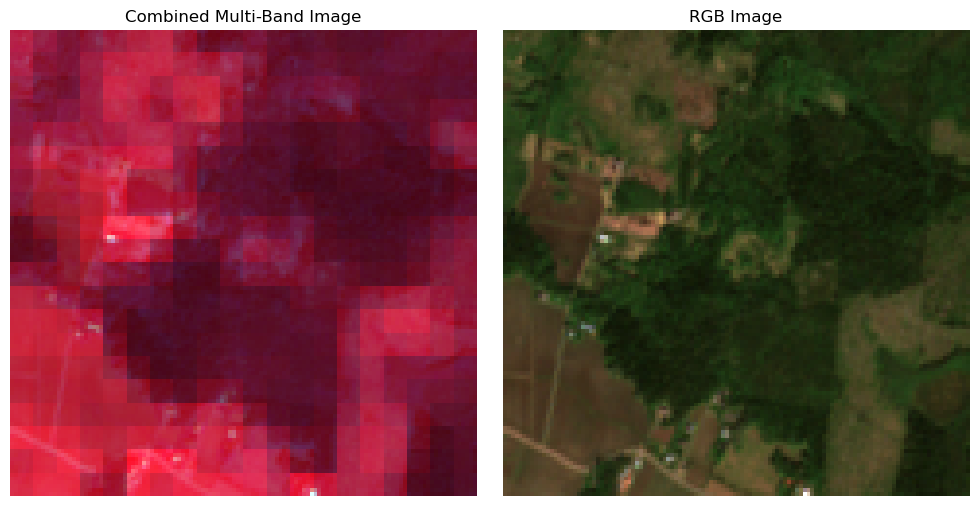

In [27]:
# Example usage
output_path = r"C:\Users\isaac\Desktop\BigEarthTests\SmallerSubset\CombinedImages\S2A_MSIL2A_20170613T101031_N9999_R022_T34VER\S2A_MSIL2A_20170613T101031_N9999_R022_T34VER_27_77.tif"

combined_image = display_combined_image(output_path)
rgb_image = display_rgb_image(output_path)

# Plot the images side by side
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(combined_image)
plt.title('Combined Multi-Band Image')
plt.axis('off')  # Hide axes

plt.subplot(1, 2, 2)
plt.imshow(rgb_image)
plt.title('RGB Image')
plt.axis('off')  # Hide axes

plt.tight_layout()
plt.show()

In [63]:
# Code to filter the metadata CSV file to only include the patches in the subset directory

# Path to the original metadata CSV file
original_csv_path = r'C:\Users\isaac\Downloads\metadata_with_binary_vectors.csv'

# Path to the subset directory
subset_dir = r'C:\Users\isaac\Desktop\BigEarthTests\OnePercentBigEarthNet'
# Read the original metadata CSV file
original_metadata = pd.read_csv(original_csv_path)

# Get the list of subset patches
subset_patches = []
for foldername, subfolders, filenames in os.walk(subset_dir):
    for filename in filenames:
        # Extract the patch identifier from the filename without the .tif extension
        patch_id = os.path.splitext(filename)[0]
        print(patch_id)
        subset_patches.append(patch_id)


# Remove duplicates from the list of subset patches
subset_patches = list(set(subset_patches))

# Filter the original metadata to only include subset patches
filtered_metadata = original_metadata[original_metadata['patch_id'].isin(subset_patches)]

# Path to the new CSV file for the subset metadata
subset_csv_path = r'C:\Users\isaac\Desktop\BigEarthTests\subset_1percent_metadata.csv'

# Save the filtered metadata to the new CSV file
filtered_metadata.to_csv(subset_csv_path, index=False)

print(f"Filtered metadata saved to {subset_csv_path}")

S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_29_59
S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_31_59
S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_32_55
S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_34_51
S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_40_57
S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_41_67
S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_41_90
S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_46_69
S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_55_52
S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_59_67
S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_59_69
S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_61_74
S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_62_86
S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_63_52
S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_65_40
S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_66_67
S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_67_47
S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_67_88
S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_69_43
S2A_MSIL2A_20170613T101031_N999

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [78]:
# Paths to the original metadata CSV files
metadata_csv_path = r'C:\Users\isaac\Downloads\metadata.csv'
binary_vectors_csv_path = r'C:\Users\isaac\Downloads\metadata_with_binary_vectors.csv'

# Path to the subset directory
subset_dir = r'C:\Users\isaac\Desktop\BigEarthTests\OnePercentBigEarthNet'

# Read the original metadata CSV files
metadata = pd.read_csv(metadata_csv_path)
binary_vectors = pd.read_csv(binary_vectors_csv_path)

# Merge the metadata DataFrame with the binary vectors DataFrame on 'patch_id'
merged_metadata = pd.merge(metadata, binary_vectors, on='patch_id')

# Get the list of subset patches
subset_patches = []
for foldername, subfolders, filenames in os.walk(subset_dir):
    for filename in filenames:
        # Extract the patch identifier from the filename without the .tif extension
        patch_id = os.path.splitext(filename)[0]
        subset_patches.append(patch_id)

# Remove duplicates from the list of subset patches
subset_patches = list(set(subset_patches))

# Filter the merged metadata to only include subset patches
filtered_metadata = merged_metadata[merged_metadata['patch_id'].isin(subset_patches)]

# Paths to the new CSV and Parquet files for the subset metadata
subset_csv_path = r'C:\Users\isaac\Desktop\BigEarthTests\one_percent_metadata.csv'
subset_parquet_path = r'C:\Users\isaac\Desktop\BigEarthTests\one_percent_metadata.parquet'

# Save the filtered metadata to the new CSV file
filtered_metadata.to_csv(subset_csv_path, index=False)

# Save the filtered metadata to the new Parquet file
filtered_metadata.to_parquet(subset_parquet_path, index=False)

print(f"Filtered metadata saved to {subset_csv_path} and {subset_parquet_path}")

Filtered metadata saved to C:\Users\isaac\Desktop\BigEarthTests\one_percent_metadata.csv and C:\Users\isaac\Desktop\BigEarthTests\one_percent_metadata.parquet


In [30]:
import ee
import geemap

# Initialize Earth Engine
ee.Initialize()

# Define the area of interest
lat, lon = 35.895037, 14.473039  # Example coordinates
point = ee.Geometry.Point([lon, lat])

# Load Sentinel-2 data and filter by cloud coverage
cloud_coverage_threshold = 1  # Set the threshold for cloud coverage (in percentage)

sentinel2 = ee.ImageCollection('COPERNICUS/S2_SR') \
    .filterBounds(point) \
    .filterDate('2020-01-01', '2023-12-31') \
    .filter(ee.Filter.lte('CLOUDY_PIXEL_PERCENTAGE', cloud_coverage_threshold)) \
    .first()  # Get the first available image that meets the criteria

# Check if sentinel2 is empty
if sentinel2 is None:
    print("No images found for the specified date and location.")
else:
    # Define bands and their respective resolutions and target export sizes
    bands_with_resolutions = {
        'B1': (20, 20),    # 20m resolution, target 20m x 20m
        'B9': (20, 20),    # 20m resolution, target 20m x 20m
        'B2': (10, 120),    # 10m resolution, target 120m x 120m
        'B3': (10, 120),    # 10m resolution, target 120m x 120m
        'B4': (10, 120),    # 10m resolution, target 120m x 120m
        'B8': (10, 120),    # 10m resolution, target 120m x 120m
        'B5': (20, 60),     # 20m resolution, target 60m x 60m
        'B6': (20, 60),     # 20m resolution, target 60m x 60m
        'B7': (20, 60),     # 20m resolution, target 60m x 60m
        'B8A': (20, 60),    # 20m resolution, target 60m x 60m
        'B11': (20, 60),    # 20m resolution, target 60m x 60m
        'B12': (20, 60)     # 20m resolution, target 60m x 60m
    }

    # Export each band with the appropriate resolution
    for band, (scale, target_size) in bands_with_resolutions.items():
        image_band = sentinel2.select(band)

        # Convert target size from meters to the buffer size needed in meters
        target_size_meters = target_size * scale
        
        # Create a region based on the center point and target size
        region = point.buffer(target_size_meters / 2).bounds()

        # Check if the image band exists
        if image_band is None or region is None:
            print(f"No valid data for {band}. Skipping export.")
            continue

        # Update the path to save in your Desktop folder
        geemap.ee_export_image(
            image_band,
            filename=f"C:/Users/isaac/Desktop/Sentinel2-patches/{band}.tif",  # Change path as needed
            scale=scale,
            region=region  # Use the defined region
        )

    print("Export completed successfully.")


Generating URL ...
Please wait ...
Data downloaded to C:\Users\isaac\Desktop\Sentinel2-patches\B1.tif
Generating URL ...
Please wait ...
Data downloaded to C:\Users\isaac\Desktop\Sentinel2-patches\B9.tif
Generating URL ...
Please wait ...
Data downloaded to C:\Users\isaac\Desktop\Sentinel2-patches\B2.tif
Generating URL ...
Please wait ...
Data downloaded to C:\Users\isaac\Desktop\Sentinel2-patches\B3.tif
Generating URL ...
Please wait ...
Data downloaded to C:\Users\isaac\Desktop\Sentinel2-patches\B4.tif
Generating URL ...
Please wait ...
Data downloaded to C:\Users\isaac\Desktop\Sentinel2-patches\B8.tif
Generating URL ...
Please wait ...
Data downloaded to C:\Users\isaac\Desktop\Sentinel2-patches\B5.tif
Generating URL ...
Please wait ...
Data downloaded to C:\Users\isaac\Desktop\Sentinel2-patches\B6.tif
Generating URL ...
Please wait ...
Data downloaded to C:\Users\isaac\Desktop\Sentinel2-patches\B7.tif
Generating URL ...
Please wait ...
Data downloaded to C:\Users\isaac\Desktop\Senti

In [12]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

def display_rgb_image(red_path, green_path, blue_path):
    # Read the bands for Red, Green, and Blue
    with rasterio.open(red_path) as red_src:
        red_band = red_src.read(1)  # Read Red band (B04)

    with rasterio.open(green_path) as green_src:
        green_band = green_src.read(1)  # Read Green band (B03)

    with rasterio.open(blue_path) as blue_src:
        blue_band = blue_src.read(1)  # Read Blue band (B02)

    # Normalize RGB bands for display
    def normalize(band):
        max_val = np.max(band)
        return band / max_val if max_val > 0 else band

    red_band = normalize(red_band)
    green_band = normalize(green_band)
    blue_band = normalize(blue_band)

    # Stack the bands into an RGB image
    rgb_image = np.dstack((red_band, green_band, blue_band))

    # Display the RGB image
    plt.figure(figsize=(5, 5))
    plt.imshow(rgb_image)
    plt.axis('off')  # Hide axis
    plt.show()

    return rgb_image  # Return the RGB image if needed


In [ ]:
# Specify the paths to your TIFF files
red_path = r'S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_28_61_B04.tif'   # Red band
green_path = r'C:/Users/isaac/Desktop/Sentinel2-patches/B3.tif'  # Green band
blue_path = r'C:/Users/isaac/Desktop/Sentinel2-patches/B2.tif'   # Blue band

# Call the function with the paths
rgb_image = display_rgb_image(red_path, green_path, blue_path)


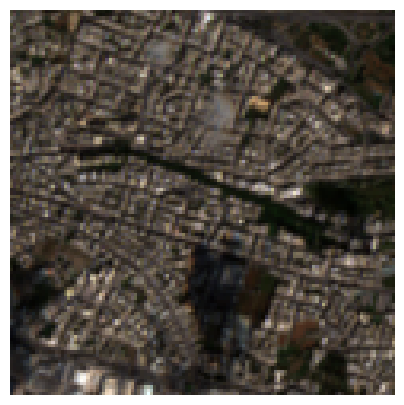

In [32]:
# Specify the paths to your TIFF files
red_path = r'C:\Users\isaac\Desktop\Sentinel2-patches\B4.tif'   # Red band
green_path = r'C:/Users/isaac/Desktop/Sentinel2-patches/B3.tif'  # Green band
blue_path = r'C:/Users/isaac/Desktop/Sentinel2-patches/B2.tif'   # Blue band

# Call the function with the paths
rgb_image = display_rgb_image(red_path, green_path, blue_path)


In [101]:
# Define the patch_id
patch_id = "S2B_MSIL2A_20170927T094019_N9999_R036_T35ULB_48_62"

# Fetch the labels for the given patch_id
labels = metadata_df.loc[metadata_df['patch_id'] == patch_id, 'labels'].values

# Print the labels
if labels.size > 0:
    print(f"Labels for patch_id '{patch_id}': {labels[0]}")
else:
    print(f"No labels found for patch_id '{patch_id}'")

Labels for patch_id 'S2B_MSIL2A_20170927T094019_N9999_R036_T35ULB_48_62': ['Urban fabric']


In [83]:
# Load the metadata
metadata_df = pd.read_parquet(r'C:\Users\isaac\Downloads\metadata.parquet')
subset_metadata_df = pd.read_parquet(r'C:\Users\isaac\Desktop\BigEarthTests\one_percent_metadata.parquet')
# Load the metadata for the snow/cloud/shadow data
#snow_cloud_shadow_metadata_df = pd.read_parquet(r'C:\Users\isaac\Downloads\metadata_for_patches_with_snow_cloud_or_shadow.parquet')

#metadata_csv = pd.read_csv(r'C:\Users\isaac\Desktop\BigEarthTests\one_percent_metadata.csv')

# Base directories
source_dir = r'C:\Users\isaac\Desktop\BigEarthTests\BigEarthSubset1'

In [81]:
metadata_df.head()

patch_id  \
0  S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_2...   
1  S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_3...   
2  S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_3...   
3  S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_3...   
4  S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_4...   

                                              labels split  country  \
0  ['Arable land', 'Broad-leaved forest', 'Land p...  test  Austria   
1  ['Arable land', 'Complex cultivation patterns'...  test  Austria   
2  ['Arable land', 'Complex cultivation patterns'...  test  Austria   
3  ['Arable land', 'Coniferous forest', 'Inland w...  test  Austria   
4                        ['Arable land', 'Pastures']  test  Austria   

                                        s1_name  \
0  S1B_IW_GRDH_1SDV_20170612T165809_33UUP_29_59   
1  S1B_IW_GRDH_1SDV_20170612T165809_33UUP_31_59   
2  S1B_IW_GRDH_1SDV_20170612T165809_33UUP_32_55   
3  S1B_IW_GRDH_1SDV_20170612T165809_33UUP_34_51   
4  S1B_IW_GRDH_1SDV_20170612T165809_33UUP_40_57   

                          s2v1_name  contains_seasonal_snow  \
0  S2A_MSIL2A_20170613T101031_29_59                   False   
1  S2A_MSIL2A_20170613T101031_31_59                   False   
2  S2A_MSIL2A_20170613T101031_32_55                   False   
3  S2A_MSIL2A_20170613T101031_34_51                   False   
4  S2A_MSIL2A_20170613T101031_40_57                   False   

   contains_cloud_or_shadow  \
0                     False   
1                     False   
2                     False   
3                     False   
4                     False   

                                       binary_vector  Arable land  ...  \
0  [1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, ...            1  ...   
1  [1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, ...            1  ...   
2  [1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...            1  ...   
3  [1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...            1  ...   
4  [1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...            1  ...   

   Industrial or commercial units  Inland wetlands  \
0                               0                0   
1                               0                0   
2                               0                0   
3                               0                0   
4                               0                0   

   Transitional woodland, shrub  \
0                             0   
1                             0   
2                             0   
3                             0   
4                             0   

   Natural grassland and sparsely vegetated areas  \
0                                               0   
1                                               0   
2                                               0   
3                                               0   
4                                               0   

   Moors, heathland and sclerophyllous vegetation  Marine waters  \
0                                               0              0   
1                                               0              0   
2                                               0              0   
3                                               0              0   
4                                               0              0   

   Coastal wetlands  Permanent crops  Beaches, dunes, sands  \
0                 0                0                      0   
1                 0                0                      0   
2                 0                0                      0   
3                 0                0                      0   
4                 0                0                      0   

   Agro-forestry areas  
0                    0  
1                    0  
2                    0  
3                    0  
4                    0  

[5 rows x 28 columns]

In [86]:
subset_metadata_df.head()

patch_id  \
0  S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_2...   
1  S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_3...   
2  S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_3...   
3  S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_3...   
4  S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_4...   

                                              labels split  country  \
0  ['Arable land', 'Broad-leaved forest', 'Land p...  test  Austria   
1  ['Arable land', 'Complex cultivation patterns'...  test  Austria   
2  ['Arable land', 'Complex cultivation patterns'...  test  Austria   
3  ['Arable land', 'Coniferous forest', 'Inland w...  test  Austria   
4                        ['Arable land', 'Pastures']  test  Austria   

                                        s1_name  \
0  S1B_IW_GRDH_1SDV_20170612T165809_33UUP_29_59   
1  S1B_IW_GRDH_1SDV_20170612T165809_33UUP_31_59   
2  S1B_IW_GRDH_1SDV_20170612T165809_33UUP_32_55   
3  S1B_IW_GRDH_1SDV_20170612T165809_33UUP_34_51   
4  S1B_IW_GRDH_1SDV_20170612T165809_33UUP_40_57   

                          s2v1_name  contains_seasonal_snow  \
0  S2A_MSIL2A_20170613T101031_29_59                   False   
1  S2A_MSIL2A_20170613T101031_31_59                   False   
2  S2A_MSIL2A_20170613T101031_32_55                   False   
3  S2A_MSIL2A_20170613T101031_34_51                   False   
4  S2A_MSIL2A_20170613T101031_40_57                   False   

   contains_cloud_or_shadow  \
0                     False   
1                     False   
2                     False   
3                     False   
4                     False   

                                       binary_vector  Arable land  ...  \
0  [1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, ...            1  ...   
1  [1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, ...            1  ...   
2  [1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...            1  ...   
3  [1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...            1  ...   
4  [1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...            1  ...   

   Industrial or commercial units  Inland wetlands  \
0                               0                0   
1                               0                0   
2                               0                0   
3                               0                0   
4                               0                0   

   Transitional woodland, shrub  \
0                             0   
1                             0   
2                             0   
3                             0   
4                             0   

   Natural grassland and sparsely vegetated areas  \
0                                               0   
1                                               0   
2                                               0   
3                                               0   
4                                               0   

   Moors, heathland and sclerophyllous vegetation  Marine waters  \
0                                               0              0   
1                                               0              0   
2                                               0              0   
3                                               0              0   
4                                               0              0   

   Coastal wetlands  Permanent crops  Beaches, dunes, sands  \
0                 0                0                      0   
1                 0                0                      0   
2                 0                0                      0   
3                 0                0                      0   
4                 0                0                      0   

   Agro-forestry areas  
0                    0  
1                    0  
2                    0  
3                    0  
4                    0  

[5 rows x 28 columns]

In [89]:
# Extract unique labels from the metadata dataframe
unique_labels = metadata_df['labels'].explode().unique()
labels = {i: label for i, label in enumerate(unique_labels)}
print(labels)

# Reverse the labels dictionary
rev = {label: i for i, label in labels.items()} 


{0: 'Arable land', 1: 'Broad-leaved forest', 2: 'Mixed forest', 3: 'Pastures', 4: 'Inland waters', 5: 'Coniferous forest', 6: 'Complex cultivation patterns', 7: 'Land principally occupied by agriculture, with significant areas of natural vegetation', 8: 'Urban fabric', 9: 'Industrial or commercial units', 10: 'Inland wetlands', 11: 'Transitional woodland, shrub', 12: 'Natural grassland and sparsely vegetated areas', 13: 'Moors, heathland and sclerophyllous vegetation', 14: 'Marine waters', 15: 'Coastal wetlands', 16: 'Permanent crops', 17: 'Beaches, dunes, sands', 18: 'Agro-forestry areas'}


In [95]:
import ast

# Ensure that the labels column contains lists
subset_metadata_df['labels'] = subset_metadata_df['labels'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Flatten the lists of labels and extract unique labels
unique_labels = subset_metadata_df['labels'].explode().explode().unique()

# Create a dictionary mapping indices to labels
labels = {i: label for i, label in enumerate(unique_labels)}
print(labels)

# Reverse the labels dictionary
rev = {label: i for i, label in labels.items()}
print(rev)

{0: 'Arable land', 1: 'Broad-leaved forest', 2: 'Land principally occupied by agriculture, with significant areas of natural vegetation', 3: 'Pastures', 4: 'Urban fabric', 5: 'Complex cultivation patterns', 6: 'Coniferous forest', 7: 'Inland waters', 8: 'Mixed forest', 9: 'Industrial or commercial units', 10: 'Inland wetlands', 11: 'Transitional woodland, shrub', 12: 'Natural grassland and sparsely vegetated areas', 13: 'Marine waters', 14: 'Moors, heathland and sclerophyllous vegetation', 15: 'Permanent crops', 16: 'Agro-forestry areas', 17: 'Beaches, dunes, sands', 18: 'Coastal wetlands'}
{'Arable land': 0, 'Broad-leaved forest': 1, 'Land principally occupied by agriculture, with significant areas of natural vegetation': 2, 'Pastures': 3, 'Urban fabric': 4, 'Complex cultivation patterns': 5, 'Coniferous forest': 6, 'Inland waters': 7, 'Mixed forest': 8, 'Industrial or commercial units': 9, 'Inland wetlands': 10, 'Transitional woodland, shrub': 11, 'Natural grassland and sparsely vege

In [106]:
import random

# List to store the counts and patch_ids
label_counts = []

# Iterate through each unique label and count the number of images with only that label
for label in unique_labels:
    # Filter the DataFrame to get rows with only the current label
    filtered_df = subset_metadata_df[subset_metadata_df['labels'].apply(lambda x: x == [label])]
    
    # Get the count of such rows
    count = filtered_df.shape[0]
    
    # Get the list of patch_ids
    patch_ids = filtered_df['patch_id'].tolist()
    
    # Append the label, count, and patch_ids to the list
    label_counts.append((label, count, patch_ids))

# Sort the list of tuples by the count in ascending order
label_counts.sort(key=lambda x: x[1])

# Dictionary to store a random patch_id for each label
random_patch_ids = {}

# Print the sorted counts and patch_ids, and save a random patch_id for each label
for label, count, patch_ids in label_counts:
    print(f"Number of images with only '{label}' label: {count}")
    
    if count > 0:
        # Select a random patch_id from the list
        random_patch_id = random.choice(patch_ids)
        random_patch_ids[label] = random_patch_id

print()
# Print the random patch_ids for each label
print("Random patch IDs for each label:")
for label, patch_id in random_patch_ids.items():
    print(f"Label: {label}, Random Patch ID: {patch_id}")

Number of images with only 'Industrial or commercial units' label: 0
Number of images with only 'Natural grassland and sparsely vegetated areas' label: 0
Number of images with only 'Beaches, dunes, sands' label: 0
Number of images with only 'Coastal wetlands' label: 0
Number of images with only 'Land principally occupied by agriculture, with significant areas of natural vegetation' label: 1
Number of images with only 'Complex cultivation patterns' label: 1
Number of images with only 'Inland wetlands' label: 3
Number of images with only 'Urban fabric' label: 4
Number of images with only 'Moors, heathland and sclerophyllous vegetation' label: 4
Number of images with only 'Mixed forest' label: 6
Number of images with only 'Transitional woodland, shrub' label: 6
Number of images with only 'Permanent crops' label: 7
Number of images with only 'Agro-forestry areas' label: 13
Number of images with only 'Inland waters' label: 24
Number of images with only 'Broad-leaved forest' label: 36
Number

In [1]:
  def __getitem__(self, idx):
        row = self.df.loc[idx]
        img_id = row["Image"]
        img_fname = self.root_dir + os.sep + str(img_id) + ".png"
        
        img = Image.open(img_fname).convert("RGB")
        img = img.resize(self.img_size, resample=3)
        img = self.transforms(img)
        
        if self.is_test:
            return img, img_id
    
        return img, encode_label(row["Label"])


 def val_dataloader(self):
        # Create validation dataloader object.
        valid_loader = DataLoader(
            self.valid_ds, batch_size=self.batch_size, pin_memory=self.pin_memory, 
            shuffle=self.shuffle_validation, num_workers=self.num_workers
        )
        return valid_loader

# Get the validation data loader.

valid_loader = dm.val_dataloader()
plt.figure(figsize=(15, 15))
for X, y in valid_loader:

    images = denormalize(X, mean=DatasetConfig.MEAN, std=DatasetConfig.STD).permute(0, 2, 3, 1).numpy()
    targets = y.numpy()

    for i in range(1, 26):
        plt.subplot(5, 5, i)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i])

        target = " ".join([str(idx) for idx, cls_id in enumerate(targets[i]) if cls_id])
        plt.title(f"{target}", fontsize=12)

    plt.suptitle('Dataset Samples', fontsize=18)
    plt.tight_layout()
    plt.show()
    plt.close()
    break